## **相关性**

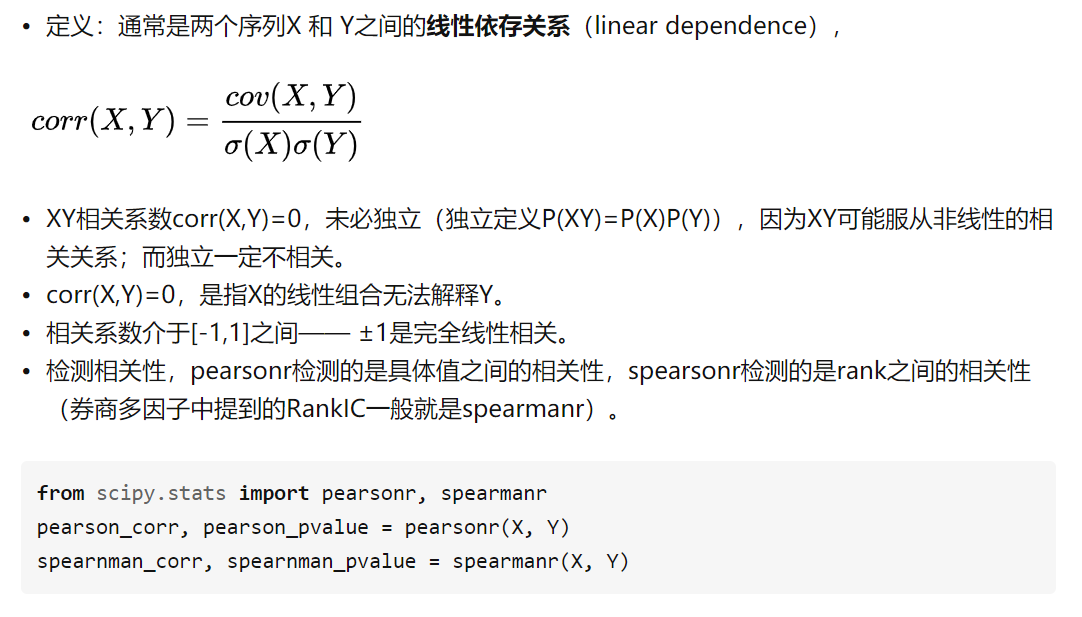

## **协整（Cointegration）**

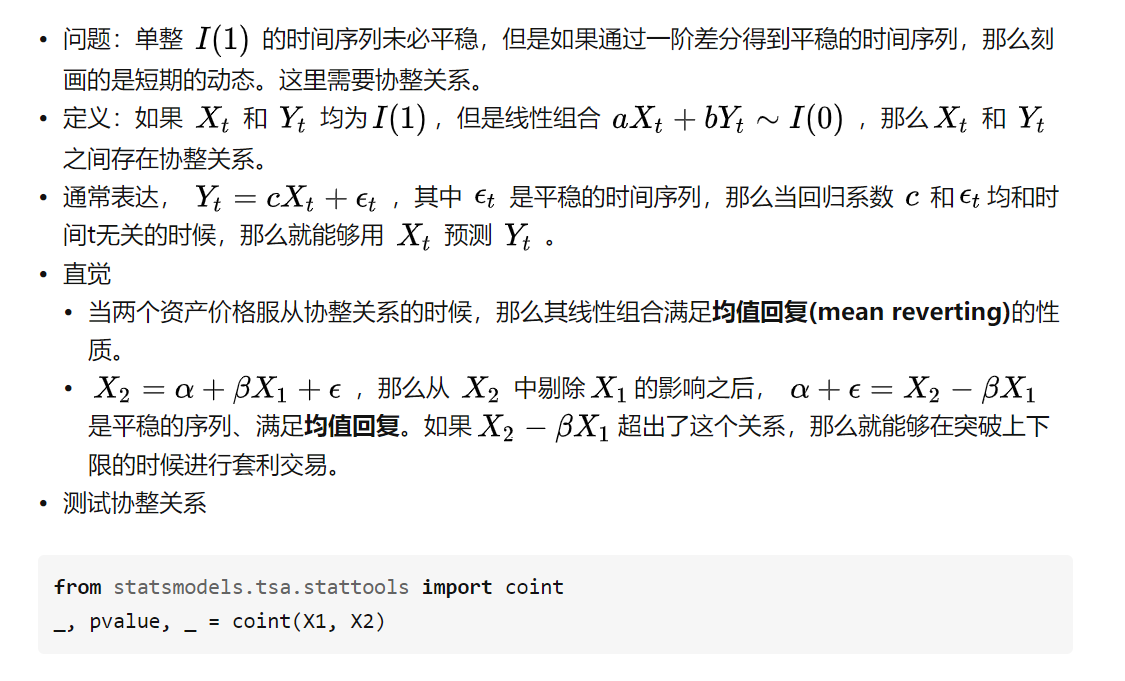

In [3]:
# 协整不一定相关
import pandas as pd 
import numpy as np
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from pylab import mpl
%matplotlib inline
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

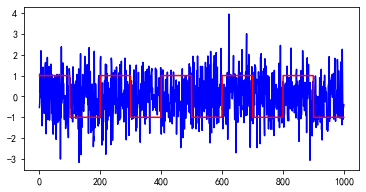

In [4]:
x1 = pd.Series(np.random.normal(0,1,1000))
x2 = x1.copy()
for i in range(10):
    x2[(100*i):(100*i+100)] = (-1)**i
    
plt.figure(figsize=(6,3))
plt.plot(x1, c='blue')
plt.plot(x2, c='red')
plt.show()

In [12]:
_, pv, _ = coint(x1,x2)
print("Cointegration test p-value :", pv)
correl, _ = pearsonr(x1,x2)
print("Correlation :", correl)

Cointegration test p-value : 0.0
Correlation : -0.007561390741832966


In [11]:
coint_x = coint(x1,x2)
print("Cointegration test p-value :", coint_x)
correl_x = pearsonr(x1,x2)
print("Correlation :", correl_x)

Cointegration test p-value : (-32.55460494412561, 0.0, array([-3.90743646, -3.34225305, -3.04869817]))
Correlation : (-0.007561390741832966, 0.811247858266652)


**结果：协整关系非常显著p-value = 0.0；但是基本没有相关性。**

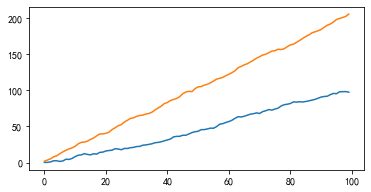

Cointegration test p-value : 0.29683189289886
Correlation : 0.9951609494272191


In [13]:
ret1 = np.random.normal(1,1,100)
ret2 = np.random.normal(2,1,100)
s1 = pd.Series(np.cumsum(ret1))
s2 = pd.Series(np.cumsum(ret2))
plt.figure(figsize=(6,3))
plt.plot(s1)
plt.plot(s2)
plt.show()

_, pv, _ = coint(s1,s2)
print("Cointegration test p-value :", pv)
correl, _ = pearsonr(s1,s2)
print("Correlation :", correl)

- **结果：相关性基本接近1，但是协整关系不显著。**

- **因此，在配对交易策略中，协整关系是重点，相关性不用考虑。**

## **配对交易策略（Paris trading）**

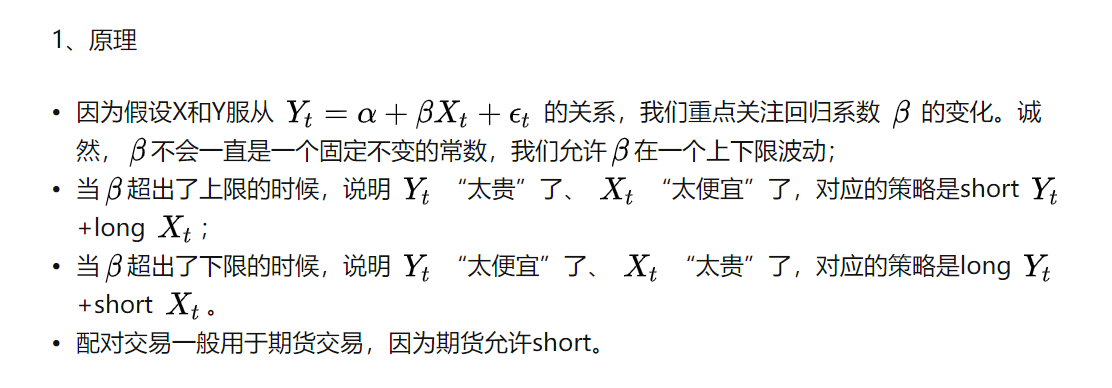

In [16]:
data = pd.read_excel('futures.xlsx')

In [17]:
# 测试相关性和协整关系
_, pv_coint, _ = coint(data['CU.SHF'], data['SF.CZC'])
corr, pv_corr = pearsonr(data['CU.SHF'], data['SF.CZC'])
print("Cointegration pvalue : %0.4f"%pv_coint)
print("Correlation coefficient is %0.4f and pvalue is %0.4f"%(corr, pv_corr))

Cointegration pvalue : 0.0000
Correlation coefficient is 0.8770 and pvalue is 0.0000


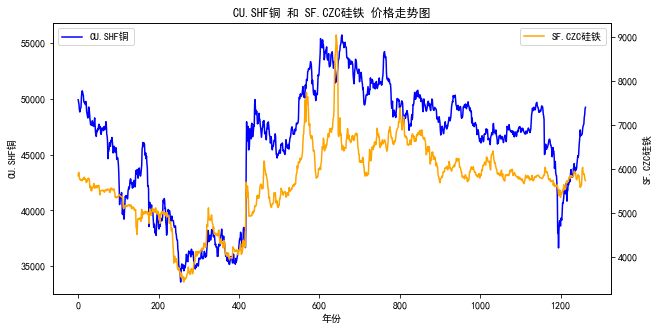

In [18]:
# 结算价走势图

def plotSettlePrice(df, var1, var2, var1_name, var2_name, title):
    temp = df[[var1, var2]].dropna()
    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(111)
    ax1.plot(temp[var1], c='blue')
    ax1.set_ylabel(var1_name)
    ax1.set_title(title)
    plt.legend(loc = 'upper left', labels=[var1_name])
    ax1.set_xlabel('年份')
    
    ax2 = ax1.twinx()
    ax2.plot(temp[var2], c='orange')
    ax2.set_ylabel(var2_name)
    ax2.set_xlabel('年份')
    plt.legend(loc = 'upper right', labels=[var2_name])
    plt.show()
    
plotSettlePrice(data, 'CU.SHF', 'SF.CZC', 'CU.SHF铜', 'SF.CZC硅铁', 'CU.SHF铜 和 SF.CZC硅铁 价格走势图')

### **计算CU.SHF结算价/SF.CZC结算价的比例Ratios**

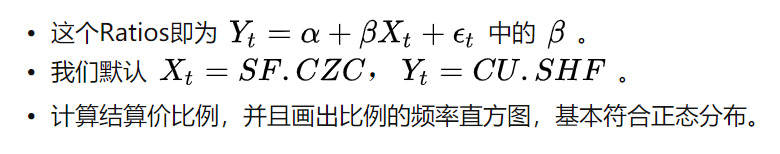

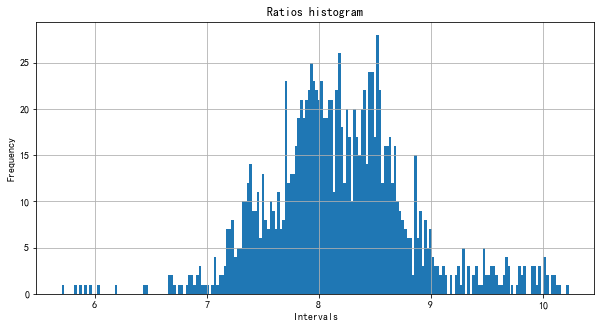

In [29]:
def getRatios(df, var1, var2, plotOrNot):
    df1 = df[[var1, var2]].dropna()
    S1 = df1[var1]
    S2 = df1[var2]
    ratios = S1 / S2  
    if plotOrNot:
        plt.figure(figsize=(10,5))            
        ratios.hist(bins = 200)
        plt.title("Ratios histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')
        plt.show()
    return S1, S2, ratios

S1, S2, ratios = getRatios(data, 'CU.SHF', 'SF.CZC', 1)

### **Z-Score**

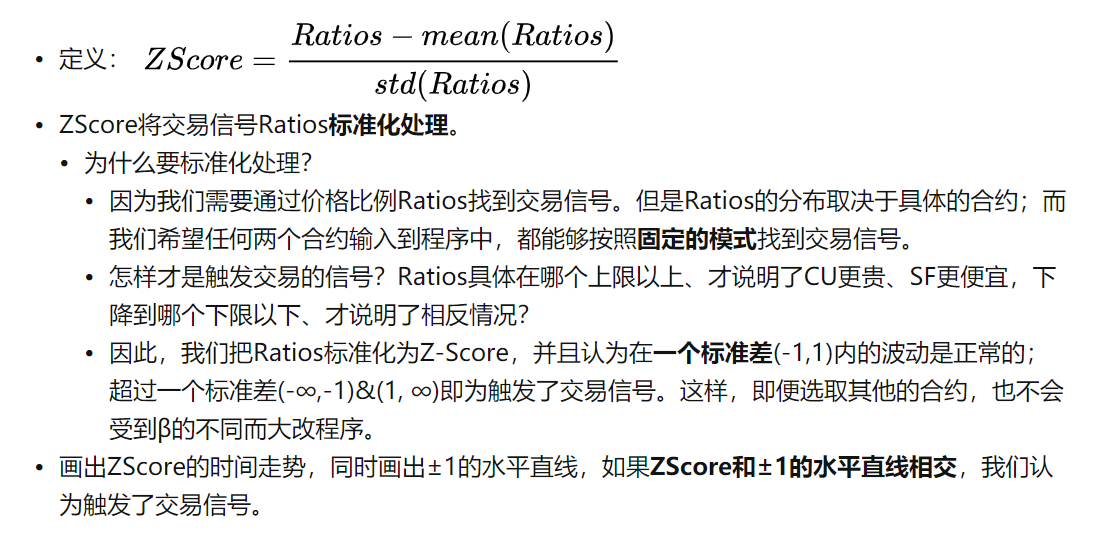

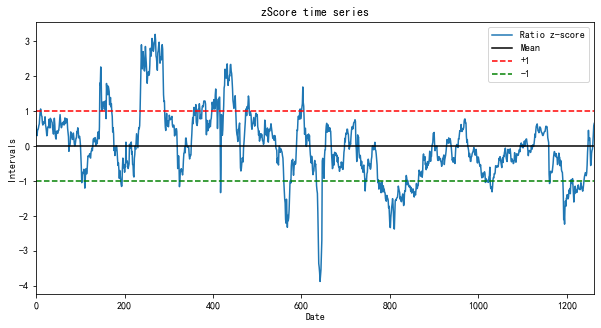

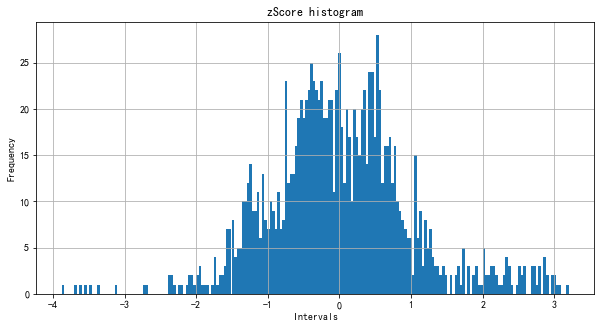

In [24]:
def getZScore(ratios, plotOrNot):
    
    zScore = (ratios - ratios.mean()) / ratios.std()    
    
    if plotOrNot:
        zScore.plot(figsize=(10,5))
        plt.axhline(zScore.mean(), color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
        plt.title("zScore time series")
        plt.xlabel('Date')
        plt.ylabel('Intervals')

        plt.show()
    
        plt.figure(figsize=(10,5))
        zScore.hist(bins = 200)
        plt.title("zScore histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')        
        plt.show()
    return zScore

zScore = getZScore(ratios, 1)

### **特征工程**

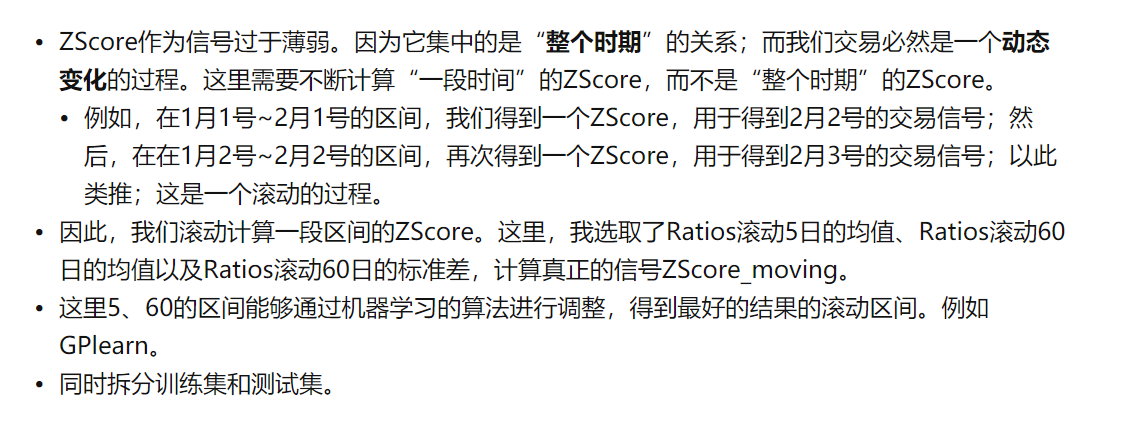

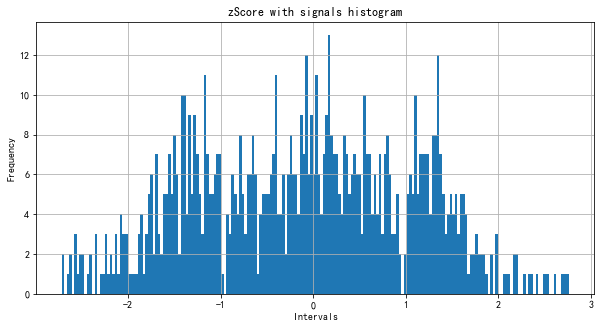

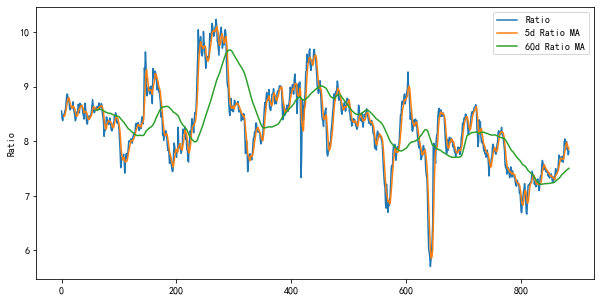

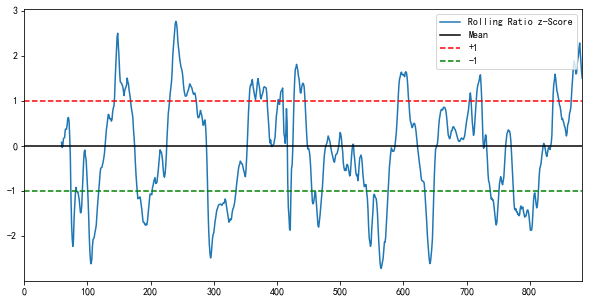

In [25]:
def getMovingIndex(ratios, train_pct, w1, w2, plotOrNot):
    ### w1 < w2，拆分训练集+验证集，训练集的比例是train_pct    
    length = len(ratios)
    trainLength = int(train_pct * length)
    train = ratios[:trainLength]
    test = ratios[trainLength:]
    
    # 计算指标moving_average, moving_std，以及moving_z_score：这里可以使用gplearn！！
    # 希望通过moving_z_score找到信号
    ratios_mavg1 = train.rolling(window=w1, center=False).mean()
    ratios_mavg2 = train.rolling(window=w2, center=False).mean()
    std = train.rolling(window=w2, center=False).std()
    zscore_mv = (ratios_mavg1 - ratios_mavg2) / std
    
    if plotOrNot:
        plt.figure(figsize=(10,5))
        zscore_mv.hist(bins = 200)
        plt.title("zScore with signals histogram")
        plt.ylabel('Frequency')
        plt.xlabel('Intervals')        
        plt.show()        
        
        plt.figure(figsize=(10,5))
        plt.plot(train.index, train.values)
        plt.plot(ratios_mavg1.index, ratios_mavg1.values)
        plt.plot(ratios_mavg2.index, ratios_mavg2.values)
        plt.legend(['Ratio','%dd Ratio MA'%w1, '%dd Ratio MA'%w2])
        plt.ylabel('Ratio')
        plt.show()    
    
        plt.figure(figsize=(10,5))
        zscore_mv.plot()
        plt.axhline(0, color='black')
        plt.axhline(1.0, color='red', linestyle='--')
        plt.axhline(-1.0, color='green', linestyle='--')
        plt.legend(loc='upper right', labels = ['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
        plt.show()
    return train, test, zscore_mv

train, test, zscore_mv = getMovingIndex(ratios, 0.7, 5, 60, 1)

### **找到交易信号**

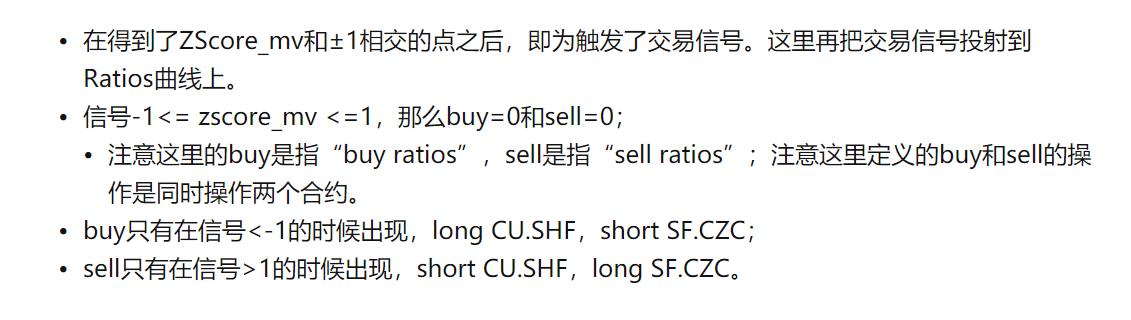

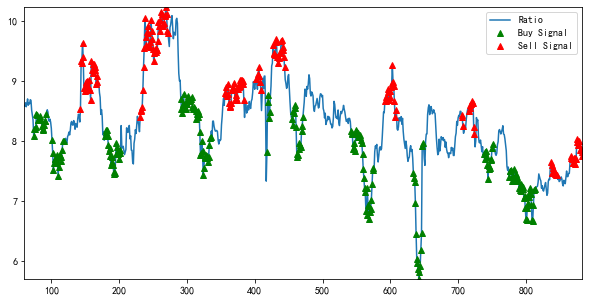

In [26]:
def getTradeSignal(train, zscore_mv, w2, plotOrNot):
    # Plot the ratios and buy and sell signals from z score
    plt.figure(figsize=(10,5))

    train[w2:].plot()
    buy = train.copy()
    sell = train.copy()
    
    # 信号ratios = CU.SHF / SF.CZC，衍生出buy和sell。
    # 其他时候ratios = 0.
    buy[zscore_mv > -1] = 0
    sell[zscore_mv < 1] = 0
    
    if plotOrNot:
        buy[60:].plot(color='g', linestyle='None', marker='^')
        sell[60:].plot(color='r', linestyle='None', marker='^')
        x1, x2, y1, y2 = plt.axis()
        plt.axis((x1,x2,ratios.min(),ratios.max()))
        plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
        plt.show()    

    return buy, sell

buy, sell = getTradeSignal(train, zscore_mv, 60, 1)

### **两个合约具体交易**

**将Ratios上找到的交易信号，再次投射到具体的合约上。**

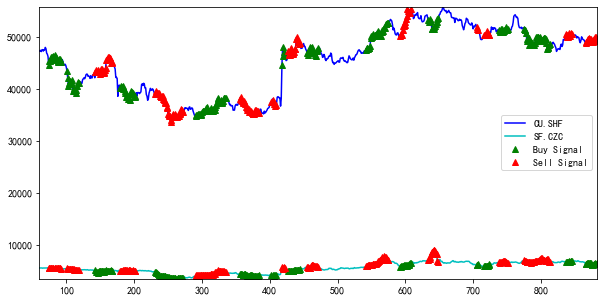

In [27]:
def Trade2Contract(df, var1, var2, buy, sell, w2):
    S1, S2, ratios = getRatios(df, var1, var2, 0)
    plt.figure(figsize=(10,5))
    S1 = S1.reindex(index = buy.index)
    S2 = S2.reindex(index = buy.index)
    S1[w2:].plot(color='b')
    S2[w2:].plot(color='c')

    # buyR和sellR先填充0。
    buyR = 0 * S1.copy()
    sellR = 0 * S1.copy()
    
    # 即buy只有在信号ratios<-1的时候保持ratios原值，此刻long S1=CU.SHF，short S2=SF.CZC
    buyR[buy!=0] = S1[buy!=0]
    sellR[buy!=0] = S2[buy!=0]

    # 即sell只有在信号ratios>1的时候保持ratios原值，此刻short S1=CU.SHF，long S2=SF.CZC。
    buyR[sell != 0] = S2[sell != 0]
    sellR[sell != 0] = S1[sell != 0]

    buyR[w2:].plot(color='g', linestyle='None', marker='^')
    sellR[w2:].plot(color='r', linestyle='None', marker='^')
    x1, x2, y1, y2 = plt.axis()
    plt.axis((x1, x2, min(S1.min(), S2.min()),max(S1.max(), S2.max())))

    plt.legend([var1, var2, 'Buy Signal', 'Sell Signal'])
    plt.show()    

Trade2Contract(data, 'CU.SHF', 'SF.CZC', buy, sell, 60)

# **总体**

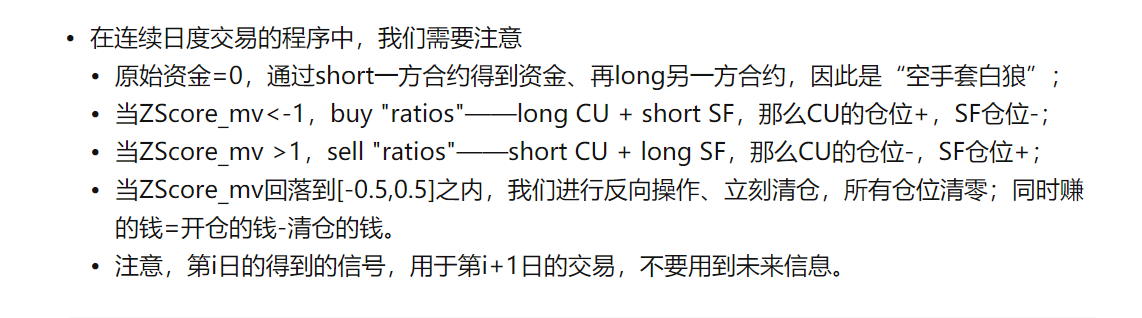

In [30]:
def PairsTrade(S1, S2, window1, window2):
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    # Compute rolling mean and rolling standard deviation
    ratios = S1 / S2
    mv_ave1 = ratios.rolling(window=window1, center=False).mean()
    mv_ave2 = ratios.rolling(window=window2, center=False).mean()
    mv_std = ratios.rolling(window=window2, center=False).std()
    zscore = (mv_ave1 - mv_ave2) / mv_std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    length = len(ratios)
    for i in range(length-1):
        
        # 如果信号zscore > 1，那么short s1（s1仓位-1）,得到的钱long s2*ratios（s1仓位+1*ratios）。
        if zscore[i] > 1:
            money += S1[i+1] - S2[i+1] * ratios[i+1]
            countS1 -= 1
            countS2 += ratios[i+1]
        
        # 如果信号zscore < -1，那么short ratios*s2,得到的钱long s1。
        elif zscore[i] < -1:
            money -= S1[i+1] - S2[i+1] * ratios[i+1]
            countS1 += 1
            countS2 -= ratios[i+1]
        
        # 如果信号zscore处在(-0.5, 0.5)之间，清仓——反向操作，用此刻的价格*此刻的仓位作为清仓的成本。同时仓位清零。
        elif abs(zscore[i]) < 0.5:
            money += countS1 * S1[i+1] + countS2 * S2[i+1]
            countS1 = 0
            countS2 = 0            
            
    return money

print(PairsTrade(S1, S2, 5, 60))

804202.5827628284
